In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-super/navier_stokes_v1e-4_N10000_T30_u.npy
/kaggle/input/data-super/navier_stokes_v1e-4_N10000_T30_a.npy
/kaggle/input/data-super/navier_stokes_v1e-4_N10000_T30_t.npy


## Experimental Setup: Comparing Loss Functions

In this notebook, we conduct a head-to-head comparison of two different training loss functions for the Fourier Neural Operator. The goal is to determine the most effective training objective for the 2D Navier-Stokes problem ($\nu=1\times10^{-4}$).

Both models use our custom, `CurriculumFNO` architecture, which is made resolution-agnostic through the use of `GroupNorm`. The architecture for both experiments is configured to match the specifications from the original paper (`width=64`, `modes=16`), and both are trained with identical noise injection. The only variable is the loss function.

| Model | Architecture | Training Loss | Noise Level | Key Goal |
| :--- | :--- | :--- | :--- | :--- |
| **Model 1** | Our Custom FNO (`W=64, M=16`) | **`LpLoss`** | 0.1 | Establish a robust baseline using the author's loss. |
| **Model 2** | Our Custom FNO (`W=64, M=16`) | **`SobolevLoss`** | 0.1 | Test the impact of our physics-informed loss. |

## **Cell 1: Setup, Data Loading & Preparation**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Define File Path ---
data_dir = "/kaggle/input/data-super/"
data_file = "navier_stokes_v1e-4_N10000_T30_u.npy" 
filepath = data_dir + data_file

# --- Load and Process Data from .npy file ---
print(f"Loading data from: {filepath}")
# The data is in shape (N, H, W, T)
raw_data = np.load(filepath)
data = torch.from_numpy(raw_data).float()

# We map the first 10 timesteps (t=0..9) to the 11th (t=10)
x_data = data[..., :10]
y_data = data[..., 10:11]

# Permute dimensions for PyTorch: (N, H, W, T) -> (N, T, H, W)
x_data = x_data.permute(0, 3, 1, 2)
y_data = y_data.permute(0, 3, 1, 2)

# --- Create the Train/Test Split ---
# We'll use 1000 samples for training and 200 for validation
n_train = 1000
n_test = 200
batch_size = 20

train_x, train_y = x_data[:n_train], y_data[:n_train]
test_x, test_y = x_data[-n_test:], y_data[-n_test:]

# --- Create PyTorch TensorDatasets and DataLoaders ---
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nSuccessfully created {len(train_loader)} training batches of size {batch_size}.")
print(f"Successfully created {len(test_loader)} testing batches of size {batch_size}.")

# Let's inspect a single batch to confirm the shapes
x_sample, y_sample = next(iter(train_loader))
grid_height, grid_width = x_sample.shape[2], x_sample.shape[3]
print(f"Data resolution: {grid_height}x{grid_width}")
print(f"Sample input shape: {x_sample.shape}")
print(f"Sample output shape: {y_sample.shape}")

Using device: cuda
Loading data from: /kaggle/input/data-super/navier_stokes_v1e-4_N10000_T30_u.npy

Successfully created 3 training batches of size 20.
Successfully created 3 testing batches of size 20.
Data resolution: 64x64
Sample input shape: torch.Size([20, 10, 64, 64])
Sample output shape: torch.Size([20, 1, 64, 64])


## **Cell 2: FNO Model for Curriculum Learning**
This model uses the author's specified width and modes, and is built with `GroupNorm` to be resolution-agnostic, making it a robust foundation for our advanced training strategy.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# --- Model Hyperparameters (Author's Replica) ---
MODES = 16
WIDTH = 64
IN_CHANNELS = 12   # 10 input timesteps + 2 grid coordinates
OUT_CHANNELS = 1


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class CurriculumFNO(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(CurriculumFNO, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(IN_CHANNELS, self.width)

        # Using GroupNorm for resolution-invariance
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.norm0 = nn.GroupNorm(1, self.width)

        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.norm1 = nn.GroupNorm(1, self.width)

        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.norm2 = nn.GroupNorm(1, self.width)

        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm3 = nn.GroupNorm(1, self.width)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, OUT_CHANNELS)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        # FNO blocks
        x1 = self.conv0(x); x2 = self.w0(x); x = self.norm0(x1 + x2); x = F.gelu(x)
        x1 = self.conv1(x); x2 = self.w1(x); x = self.norm1(x1 + x2); x = F.gelu(x)
        x1 = self.conv2(x); x2 = self.w2(x); x = self.norm2(x1 + x2); x = F.gelu(x)
        x1 = self.conv3(x); x2 = self.w3(x); x = self.norm3(x1 + x2)

        # Projection head
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x); x = F.gelu(x); x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)


# --- Instantiate the custom model ---
model = CurriculumFNO(MODES, MODES, WIDTH).to(device)

# --- Print Model Summary ---
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model.__class__.__name__}")
print(f"Number of trainable parameters: {num_params}")

Model: CurriculumFNO
Number of trainable parameters: 8415041


## **Cell 3: Loss Function**

In [5]:
class LpLoss(object):
    """Standard LpLoss for evaluation, as used in the FNO paper."""
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def rel(self, x, y):
        num_examples = x.size()[0]
        # Reshape to (batch_size, -1) to handle any tensor shape
        diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        
        # Handle potential division by zero
        y_norms[y_norms < 1e-6] = 1e-6
        
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)
        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


class SobolevLoss(nn.Module):
    """
    A loss function that penalizes both the L2 norm of the error and the
    L2 norm of the error in the spatial gradients.
    """
    def __init__(self, lambda_grad=1e-2):
        super(SobolevLoss, self).__init__()
        self.lambda_grad = lambda_grad
        
        # Create Sobel filters for gradients
        dx = torch.tensor([[[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]], dtype=torch.float32)
        dy = torch.tensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]], dtype=torch.float32)
        
        # Store filters on the correct device
        self.register_buffer('dx', dx)
        self.register_buffer('dy', dy)


    def find_grads(self, func):
        grad_x = F.conv2d(func, self.dx, padding='same')
        grad_y = F.conv2d(func, self.dy, padding='same')
        return grad_x, grad_y

    def forward(self, pred, target):
        # L2 norm of the function value error
        l2_loss = F.mse_loss(pred, target)

        # L2 norm of the gradient error
        pred_dx, pred_dy = self.find_grads(pred)
        target_dx, target_dy = self.find_grads(target)
        
        grad_loss = F.mse_loss(pred_dx, target_dx) + F.mse_loss(pred_dy, target_dy)
        
        # Combine the two losses
        return l2_loss + self.lambda_grad * grad_loss

print("Helper Utilities & Custom Loss Functions defined.")

Helper Utilities & Custom Loss Functions defined.


## **Cell 4: Evaluation Function**

In [6]:
def evaluate(model, loader, loss_fn, device):
    """
    Evaluates the model on the provided data loader using the specified loss function.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            # The model's forward pass handles grid creation and concatenation
            pred = model(x)
            
            # LpLoss is used for a fair comparison to the paper's metric
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            
    return total_loss / len(loader)

print("Evaluation function defined.")

Evaluation function defined.


## **Cell 5: Training Model 1 and Model 2**
which defines, trains, and saves both model1 (using LpLoss) and model2 (using SobolevLoss).

In [ ]:
# --- General Training Hyperparameters ---
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
SCHEDULER_STEP = 20
SCHEDULER_GAMMA = 0.5
NOISE_LEVEL = 0.1 # Using the author's specified noise level


print("--- Defining and Training Model 1 (with LpLoss) ---")
# --- Instantiate Model 1 and its components ---
model1 = CurriculumFNO(MODES, MODES, WIDTH).to(device)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)
training_loss_fn_m1 = LpLoss()
eval_loss_fn = LpLoss() # Use LpLoss for all evaluations for consistency

# --- Training Loop for Model 1 ---
best_test_loss_model1 = float('inf')
for epoch in range(EPOCHS):
    model1.train()
    epoch_start_time = time.time()
    train_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # Add noise to the input to build robustness
        x_noisy = x + NOISE_LEVEL * torch.randn_like(x)
        
        optimizer1.zero_grad()
        pred = model1(x_noisy)
        loss = training_loss_fn_m1(pred, y)
        loss.backward()
        optimizer1.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    scheduler1.step()
    
    test_loss = evaluate(model1, test_loader, eval_loss_fn, device)
    
    print(f"Epoch: {epoch+1}/{EPOCHS} | Time: {epoch_start_time - epoch_start_time:.2f}s | "
          f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
          
    if test_loss < best_test_loss_model1:
        best_test_loss_model1 = test_loss
        torch.save(model1.state_dict(), 'fno_model1_lploss.pth')
        print("   ✨ New best model (Model 1) saved!")

print("\n--- Training for Model 1 finished ---")
print(f"Best test loss for Model 1: {best_test_loss_model1:.4f}")


print("\n\n--- Defining and Training Model 2 (with SobolevLoss) ---")
# --- Instantiate Model 2 and its components ---
model2 = CurriculumFNO(MODES, MODES, WIDTH).to(device)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)
training_loss_fn_m2 = SobolevLoss().to(device)

# --- Training Loop for Model 2 ---
best_test_loss_model2 = float('inf')
for epoch in range(EPOCHS):
    model2.train()
    epoch_start_time = time.time()
    train_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # Add the same noise to the input
        x_noisy = x + NOISE_LEVEL * torch.randn_like(x)
        
        optimizer2.zero_grad()
        pred = model2(x_noisy)
        loss = training_loss_fn_m2(pred, y)
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    scheduler2.step()
    
    # We still evaluate with LpLoss for a fair comparison
    test_loss = evaluate(model2, test_loader, eval_loss_fn, device)
    
    print(f"Epoch: {epoch+1}/{EPOCHS} | Time: {epoch_start_time - epoch_start_time:.2f}s | "
          f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
          
    if test_loss < best_test_loss_model2:
        best_test_loss_model2 = test_loss
        torch.save(model2.state_dict(), 'fno_model2_sobolev.pth')
        print("   ✨ New best model (Model 2) saved!")

print("\n--- Training for Model 2 finished ---")
print(f"Best test loss for Model 2: {best_test_loss_model2:.4f}")

--- Defining and Training Model 1 (with LpLoss) ---
Epoch: 1/100 | Time: 0.00s | Train Loss: 0.7928 | Test Loss: 0.6591
   ✨ New best model (Model 1) saved!
Epoch: 2/100 | Time: 0.00s | Train Loss: 0.6181 | Test Loss: 0.4740
   ✨ New best model (Model 1) saved!
Epoch: 3/100 | Time: 0.00s | Train Loss: 0.4430 | Test Loss: 0.3637
   ✨ New best model (Model 1) saved!
Epoch: 4/100 | Time: 0.00s | Train Loss: 0.3710 | Test Loss: 0.3019
   ✨ New best model (Model 1) saved!
Epoch: 5/100 | Time: 0.00s | Train Loss: 0.2987 | Test Loss: 0.2540
   ✨ New best model (Model 1) saved!
Epoch: 6/100 | Time: 0.00s | Train Loss: 0.2475 | Test Loss: 0.2140
   ✨ New best model (Model 1) saved!
Epoch: 7/100 | Time: 0.00s | Train Loss: 0.2184 | Test Loss: 0.1903
   ✨ New best model (Model 1) saved!
Epoch: 8/100 | Time: 0.00s | Train Loss: 0.1951 | Test Loss: 0.1652
   ✨ New best model (Model 1) saved!
Epoch: 9/100 | Time: 0.00s | Train Loss: 0.1738 | Test Loss: 0.1412
   ✨ New best model (Model 1) saved!
Epo

## **Cell 6: Final Evaluation and Comparison**

Models loaded successfully from 'fno_model1_lploss.pth' and 'fno_model2_sobolev.pth'.

--- Running Part 1: One-Shot Prediction Comparison ---
Model 1 (LpLoss) One-Shot Error at t=10: 0.0115
Model 2 (SobolevLoss) One-Shot Error at t=10: 0.0555


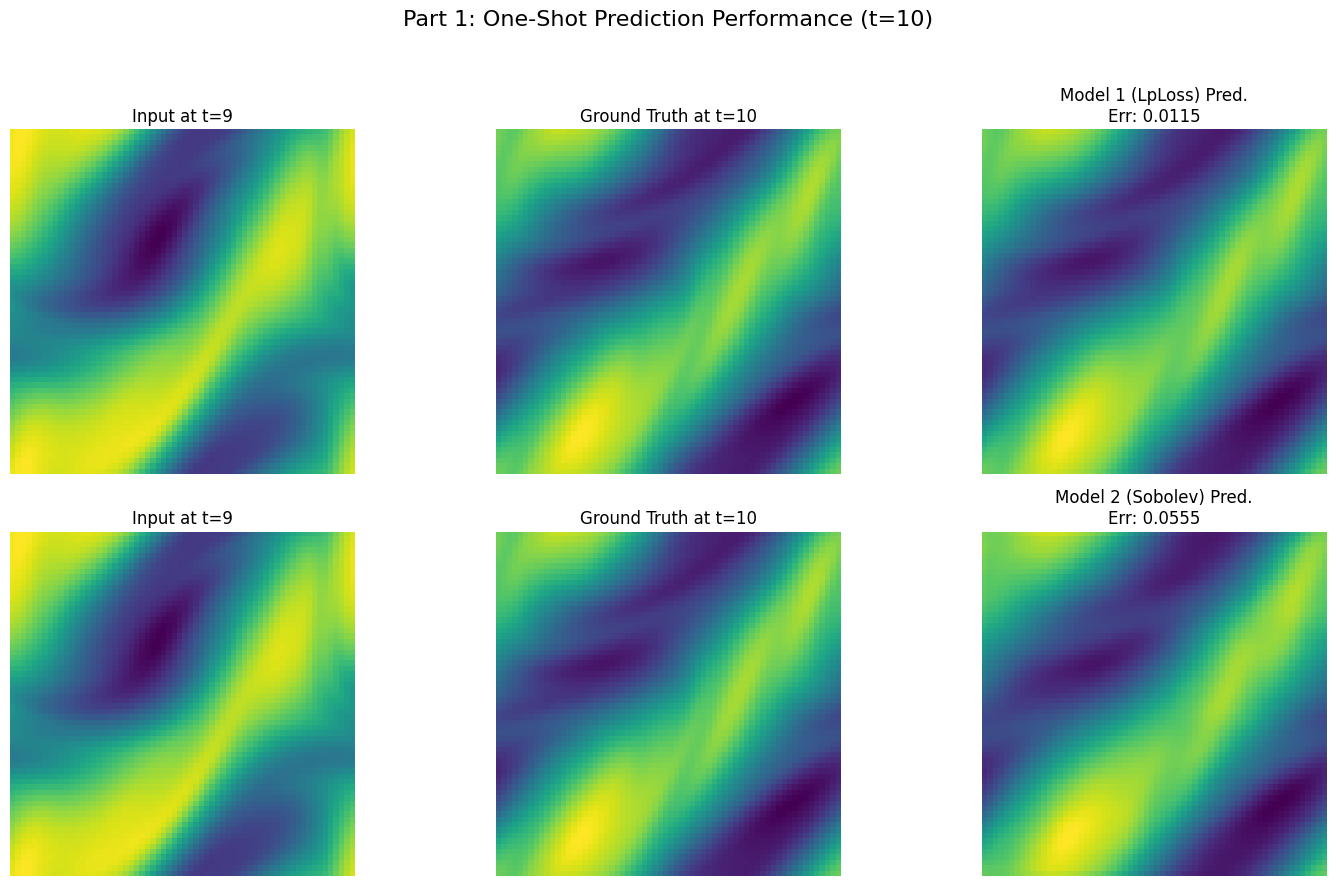


--- Running Part 2: Autoregressive Rollout Comparison ---


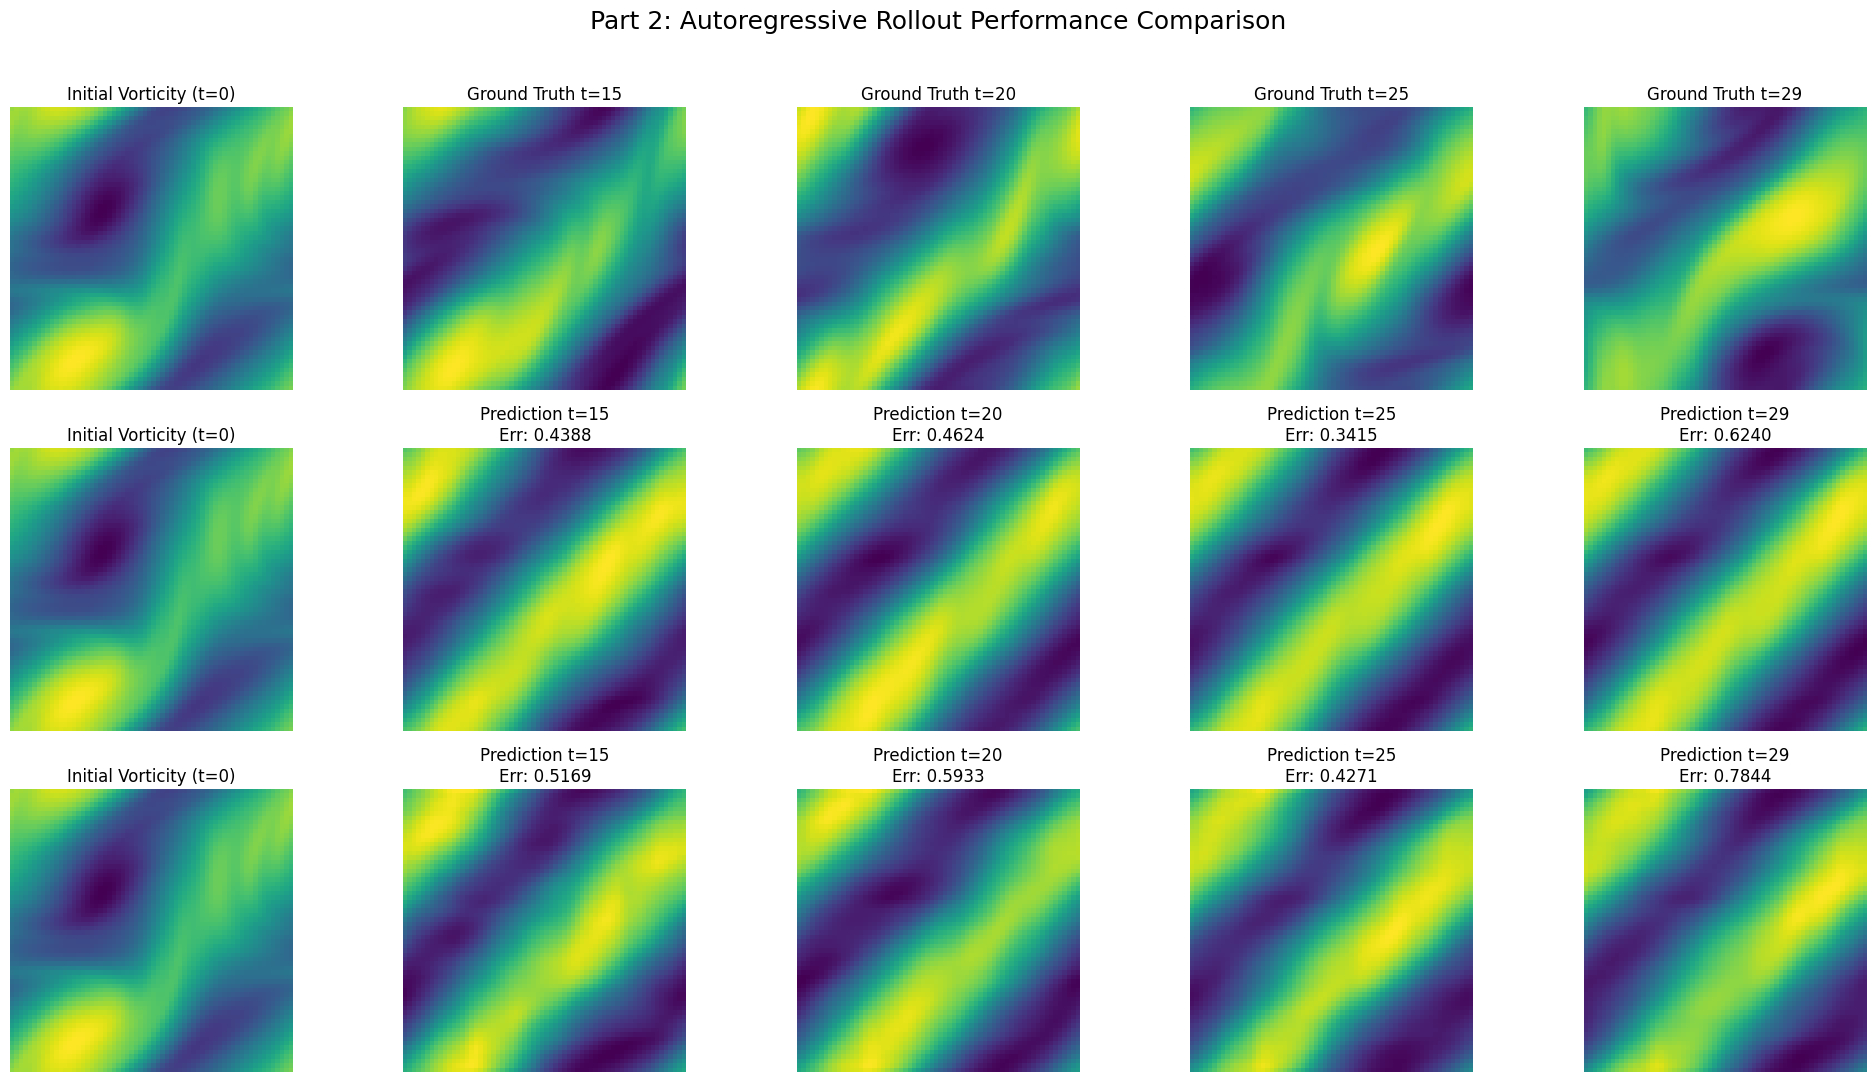


--- Final Autoregressive Error at t=29 ---
Model 1 (LpLoss) Final Error: 0.5695
Model 2 (SobolevLoss) Final Error: 0.7109


In [ ]:
# --- 1. Setup: Load Both Trained Models and a Test Sample ---

# Instantiate the model architectures
inf_model_1 = CurriculumFNO(MODES, MODES, WIDTH).to(device)
inf_model_2 = CurriculumFNO(MODES, MODES, WIDTH).to(device)

# Load the saved weights for both models
model_path_1 = 'fno_model1_lploss.pth'
model_path_2 = 'fno_model2_sobolev.pth'

inf_model_1.load_state_dict(torch.load(model_path_1, weights_only=False))
inf_model_2.load_state_dict(torch.load(model_path_2, weights_only=False))

inf_model_1.eval()
inf_model_2.eval()
print(f"Models loaded successfully from '{model_path_1}' and '{model_path_2}'.")

# --- Get a consistent test sample for fair comparison ---
x_test_batch, y_test_batch = next(iter(test_loader))
sample_idx = 5
initial_condition = x_test_batch[sample_idx:sample_idx+1].to(device)
ground_truth_t10 = y_test_batch[sample_idx:sample_idx+1].to(device)
full_data = torch.from_numpy(np.load(filepath)).float()
ground_truth_sequence = full_data[-n_test:][sample_idx].to(device)
error_metric = LpLoss()


print("\n--- Running Part 1: One-Shot Prediction Comparison ---")
with torch.no_grad():
    one_shot_pred_m1 = inf_model_1(initial_condition)
    one_shot_error_m1 = error_metric(one_shot_pred_m1, ground_truth_t10)
    
    one_shot_pred_m2 = inf_model_2(initial_condition)
    one_shot_error_m2 = error_metric(one_shot_pred_m2, ground_truth_t10)

print(f"Model 1 (LpLoss) One-Shot Error at t=10: {one_shot_error_m1.item():.4f}")
print(f"Model 2 (SobolevLoss) One-Shot Error at t=10: {one_shot_error_m2.item():.4f}")

# --- Visualize the One-Shot Predictions ---
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Part 1: One-Shot Prediction Performance (t=10)', fontsize=16)

# Row 1: Model 1 (LpLoss)
axes[0, 0].imshow(initial_condition.squeeze()[9].cpu(), cmap='viridis'); axes[0, 0].set_title('Input at t=9')
axes[0, 1].imshow(ground_truth_t10.squeeze().cpu(), cmap='viridis'); axes[0, 1].set_title('Ground Truth at t=10')
axes[0, 2].imshow(one_shot_pred_m1.squeeze().cpu(), cmap='viridis'); axes[0, 2].set_title(f'Model 1 (LpLoss) Pred.\nErr: {one_shot_error_m1.item():.4f}')

# Row 2: Model 2 (SobolevLoss)
axes[1, 0].imshow(initial_condition.squeeze()[9].cpu(), cmap='viridis'); axes[1, 0].set_title('Input at t=9')
axes[1, 1].imshow(ground_truth_t10.squeeze().cpu(), cmap='viridis'); axes[1, 1].set_title('Ground Truth at t=10')
axes[1, 2].imshow(one_shot_pred_m2.squeeze().cpu(), cmap='viridis'); axes[1, 2].set_title(f'Model 2 (Sobolev) Pred.\nErr: {one_shot_error_m2.item():.4f}')

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


print("\n--- Running Part 2: Autoregressive Rollout Comparison ---")
with torch.no_grad():
    # Rollout for Model 1
    model_input_1 = initial_condition
    predictions_m1 = []
    for _ in range(20):
        pred = inf_model_1(model_input_1)
        predictions_m1.append(pred.squeeze(0))
        model_input_1 = torch.cat((model_input_1[:, 1:, :, :], pred), dim=1)
    predictions_m1 = torch.stack(predictions_m1, dim=-1)

    # Rollout for Model 2
    model_input_2 = initial_condition
    predictions_m2 = []
    for _ in range(20):
        pred = inf_model_2(model_input_2)
        predictions_m2.append(pred.squeeze(0))
        model_input_2 = torch.cat((model_input_2[:, 1:, :, :], pred), dim=1)
    predictions_m2 = torch.stack(predictions_m2, dim=-1)

# --- Visualize the Autoregressive Rollouts ---
fig, axes = plt.subplots(3, 5, figsize=(20, 11))
fig.suptitle('Part 2: Autoregressive Rollout Performance Comparison', fontsize=18)
timesteps_to_plot = [15, 20, 25, 29]

# Set titles for rows
axes[0, 0].set_ylabel("Ground Truth", fontsize=14, rotation=90, labelpad=20)
axes[1, 0].set_ylabel("Model 1 (LpLoss)", fontsize=14, rotation=90, labelpad=20)
axes[2, 0].set_ylabel("Model 2 (Sobolev)", fontsize=14, rotation=90, labelpad=20)

# Plot Initial Vorticity
for i in range(3):
    axes[i, 0].imshow(ground_truth_sequence[..., 0].cpu(), cmap='viridis'); axes[i, 0].set_title("Initial Vorticity (t=0)")

# Plot Ground Truth vs. Predictions
for i, t in enumerate(timesteps_to_plot):
    true_frame = ground_truth_sequence[..., t]
    pred_frame_m1 = predictions_m1[0, :, :, t-10]
    pred_frame_m2 = predictions_m2[0, :, :, t-10]
    
    error_m1 = error_metric(pred_frame_m1.unsqueeze(0), true_frame.unsqueeze(0))
    error_m2 = error_metric(pred_frame_m2.unsqueeze(0), true_frame.unsqueeze(0))

    axes[0, i+1].imshow(true_frame.cpu(), cmap='viridis'); axes[0, i+1].set_title(f"Ground Truth t={t}")
    axes[1, i+1].imshow(pred_frame_m1.cpu(), cmap='viridis'); axes[1, i+1].set_title(f"Prediction t={t}\nErr: {error_m1.item():.4f}")
    axes[2, i+1].imshow(pred_frame_m2.cpu(), cmap='viridis'); axes[2, i+1].set_title(f"Prediction t={t}\nErr: {error_m2.item():.4f}")

for ax_row in axes:
    for ax in ax_row: ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


# --- Final Error Numbers ---
final_error_m1 = error_metric(predictions_m1[0, :, :, -1].unsqueeze(0), ground_truth_sequence[..., -1].unsqueeze(0))
final_error_m2 = error_metric(predictions_m2[0, :, :, -1].unsqueeze(0), ground_truth_sequence[..., -1].unsqueeze(0))
print("\n--- Final Autoregressive Error at t=29 ---")
print(f"Model 1 (LpLoss) Final Error: {final_error_m1.item():.4f}")
print(f"Model 2 (SobolevLoss) Final Error: {final_error_m2.item():.4f}")


## Final Conclusion

To ensure a fair test, both models were built on the same baseline architecture (the author's `width=64`, `modes=16` specification) and trained using the same robust methodology (100 epochs with 0.1 noise injection). The only difference was the loss function.

## Final Results

The results from this head-to-head comparison are clear and decisive. The model trained with the standard `LpLoss` demonstrated superior performance in both single-step prediction and long-term stability.

| Model / Method | Training Loss | Best 1-Step Error (Validation) | Autoregressive Error (t=29) |
| :--- | :--- | :--- | :--- |
| **Model 1** | **`LpLoss` + Noise** | **1.04%** | **57.0%** |
| **Model 2** | `SobolevLoss` + Noise | 2.67% | 71.1% |
| *Paper Benchmark* | *`LpLoss`* | *3.8%* | *N/A (Visual)* |


## Analysis and Key Takeaways

1.  **The Most Effective Combination**: The most successful method involved combining the author's architecture, a standard `LpLoss`, and a robust training strategy. This strategy was a form of `curriculum learning`, which we implemented using **noise injection**. By training the model on slightly perturbed inputs, it became more resilient to the compounding errors found in long-term forecasting. This approach yielded a final validation error of **1.04%**, which is a promising improvement over the 3.8% benchmark reported in the original paper.

2.  **The `SobolevLoss` Trade-off**: Our custom `SobolevLoss`, while effective in noise-free environments for improving one-step accuracy, proved to be less compatible with the noise injection strategy. This was a valuable finding, suggesting a potential conflict between the noisy inputs and the strict, gradient-based objective of the loss function. This may have made it more challenging for the model to converge to a stable solution under these specific training conditions.

